Median Year of References - Another innovation index


The general goal is to build an innovation index based on a very simple principle: the median year of the citations in an article. 

The rationale is that higher median years would indicate an active field of work, which may be a proxy for wheter an article is "innovative". 

We will gather the data from Wikidata for the year 2017. 


The first task is:  extract all years for all references in a given article.

Article of choice for testing: Q22330722 (Potential sexual transmission of Zika virus)

In [2]:
from wikidataintegrator import wdi_core

test_article_item = wdi_core.WDItemEngine(wd_item_id='Q22330722')

In [45]:
import json

import numpy as np

vint = np.vectorize(int)
article_json =  test_article_item.get_wd_json_representation()

print()

all_years = []
for reference in article_json['claims']['P2860']:
    qid_reference = reference['mainsnak']['datavalue']['value']['id']
    reference_json =  wdi_core.WDItemEngine(wd_item_id=qid_reference).get_wd_json_representation()
    year = reference_json['claims']['P577'][0]['mainsnak']['datavalue']['value']['time'][1:5]
    all_years.append(year)
    np.median(all_years)

print(all_years)


['1952', '2014', '2014', '2014', '2014', '2014', '2011', '2009', '2009', '2013', '2012', '2009', '2005', '1977', '2010']



Now let's organize this into a function: 

given a QID, the function will return the median year of the references of the article.

In [55]:
from wikidataintegrator import wdi_core
import json
import numpy as np

def median_year_reference(qid):

    vint = np.vectorize(int)
    
    test_article_item = wdi_core.WDItemEngine(wd_item_id=qid)
    article_json =  test_article_item.get_wd_json_representation()
    
    all_years = []
    for reference in article_json['claims']['P2860']:
        qid_reference = reference['mainsnak']['datavalue']['value']['id']
        reference_json =  wdi_core.WDItemEngine(wd_item_id=qid_reference).get_wd_json_representation()
        year = reference_json['claims']['P577'][0]['mainsnak']['datavalue']['value']['time'][1:5]
        all_years.append(year)
    
    all_years = vint(all_years)
    
    return(np.median(all_years))

median_year_reference("Q22330722")

2011.0

Okay, it is working, now I'm just going to test a simple hypothesis:

is the myref index correlated with citations?


For this, I will get the QIDs for Nature articles published in 2015 in the Wikidata database:

In [96]:
query = '''
SELECT ?item ?itemLabel WHERE {
  ?item wdt:P1433 wd:Q180445.
  ?item wdt:P31 wd:Q13442814.
  ?item wdt:P2860 ?ref.
  ?item  wdt:P577 ?date.
  FILTER(?date > "2014-12-31T23:59:59Z"^^xsd:dateTime)
  FILTER(?date < "2016-01-01T00:00:00Z"^^xsd:dateTime)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
}

'''

result = wdi_core.WDItemEngine.execute_sparql_query(query)

In [97]:
result_list = result['results']['bindings']

newlist = []
for i in result_list:
      if i not in newlist:
            newlist.append(i)
            
result_list = newlist

In [101]:
mini_result_list = result_list[0:10]

In [120]:
import time as time


time_before = time.time()

article_myref = dict()

for result in mini_result_list:
    qid = result['item']['value'].split('/')[4]
    print(qid)
    article_myref[qid] = median_year_reference(qid)
    
print(time.time() - time_before )

Q22251076
Q22251077
Q20666131
Q21505108
Q21534936
Q22122124
Q22122126
Q22122127
Q22305005
Q22337241
458.24058985710144


In [124]:
import time as time
time.time()
for result in mini_result_list:
    qid = result['item']['value'].split('/')[4]
    print(result['itemLabel']['value'])


Substantial contribution of extrinsic risk factors to cancer development
Evidence for human transmission of amyloid-β pathology and cerebral amyloid angiopathy
A bizarre Jurassic maniraptoran theropod with preserved evidence of membranous wings
Observation of the rare Bs0 →µ+µ− decay from the combined analysis of CMS and LHCb data
Massive migration from the steppe was a source for Indo-European languages in Europe
Hemichordate genomes and deuterostome origins
Plant biology: Coding in non-coding RNAs
The octopus genome and the evolution of cephalopod neural and morphological novelties
Genetic studies of body mass index yield new insights for obesity biology
Reducing neurodevelopmental disorders and disability through research and interventions


In [129]:
import scholarly
search_query = scholarly.search_pubs_query('Perception of physical stability and center of mass of 3D objects')

print(next(search_query))

{'_filled': False,
 'bib': {'abstract': 'Humans can judge from vision alone whether an object is '
                     'physically stable or not. Such judgments allow observers '
                     'to predict the physical behavior of objects, and hence '
                     'to guide their motor actions. We investigated the visual '
                     'estimation of physical stability of 3-D objects (shown '
                     'in stereoscopically viewed rendered scenes) and how it '
                     'relates to visual estimates of their center of mass '
                     '(COM). In Experiment 1, observers viewed an object near '
                     'the edge of a table and adjusted its tilt to the '
                     'perceived critical angle, ie, the tilt angle at which '
                     'the object …',
         'author': 'SA Cholewiak and RW Fleming and M Singh',
         'eprint': 'https://jov.arvojournals.org/article.aspx?articleID=2213254',
         'titl

This approach is ok, but we have 2 problems:
 * The function takes too long
 * The scholarly module does not return citations anymore
 
Let's build a smarter SPARQL query to automatically get all dates
 
 

In [337]:
query = '''
SELECT ?item ?itemLabel ?year ?pubmedid WHERE {
  ?item wdt:P1433 wd:Q180445.
  ?item wdt:P31 wd:Q13442814.
  ?item wdt:P2860 ?ref.
  ?ref wdt:P577 ?year.
  ?item wdt:P698 ?pubmedid.
  ?item  wdt:P577 ?date.
  
  FILTER(?date > "2014-12-31T23:59:59Z"^^xsd:dateTime)
  FILTER(?date < "2016-01-01T00:00:00Z"^^xsd:dateTime)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
}


'''

result = wdi_core.WDItemEngine.execute_sparql_query(query)

In [338]:


print(type(df.iloc[1,1]))



def get_value(binding):
    
    value = binding['value']
    
    if "http://" in value:
        value = value.split("/")[4]
    if "00:00" in value:
        value = int(value[0:4])

    
    return(value)
    
    







<class 'dict'>


In [339]:

import json
import pandas as pd

df = pd.DataFrame.from_dict(result['results']['bindings'])

clean_df = df.applymap(get_value)
myref_table = clean_df.groupby('itemLabel').median()

myref_table.index.name = 'title'
myref_table.reset_index(inplace=True)

myref_table

,title,year
0,2015 awards: China Nobel stirs up attack on ac...,2014.0
1,3.3-million-year-old stone tools from Lomekwi ...,2006.0
2,A Cretaceous eutriconodont and integument evol...,2008.0
3,A LAIR1 insertion generates broadly reactive a...,2008.0
4,A Mercury-like component of early Earth yields...,2005.0
5,A bizarre Jurassic maniraptoran theropod with ...,2007.0
6,A circuit mechanism for differentiating positi...,2007.0
7,A colloidal quantum dot spectrometer.,2006.0
8,A comprehensive phylogeny of birds (Aves) usin...,2011.0
9,A concise synthesis of (+)-batzelladine B from...,2006.0


Hooray. Problem 1 solved.

For the google scholar problem, I'm gonna do some scraping by hand. 



In [283]:
import requests
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')


def get_gs_citations(title):
    gs_query = title.replace(" ", "+")
    page = requests.get('https://scholar.google.com.br/scholar?hl=en&as_sdt=0%2C5&q=' + gs_query + '&btnG=')
    
    soup = BeautifulSoup(page.text, 'html.parser')
    citation_list = soup.select("#gs_res_ccl_mid > div > div.gs_ri > div.gs_fl > a:nth-child(3)")
    
    if len(citation_list):
        citation_text = citation_list[0].text
    else:
        return(0)
    if citation_text == "Related articles":
        return(0)

    doc = nlp(citation_text)
    citations = int(doc[2].text)

    return(citations)

In [299]:
gs_cites = [] asd a21
for title in myref_table["title"]:
    print(title)
    gs_cites.append(get_gs_citations(title))

SyntaxError: invalid syntax (<ipython-input-299-77edf4f3e8d2>, line 1)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">

<html>
<head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><meta content="initial-scale=1" name="viewport"/><title>https://scholar.google.com.br/scholar?hl=en&amp;as_sdt=0%2C5&amp;q=%E2%88%86F508+CFTR+interactome+remodelling+promotes+rescue+of+cystic+fibrosis.&amp;btnG=</title></head>
<body onload="e=document.getElementById('captcha');if(e){e.focus();}" style="font-family: arial, sans-serif; background-color: #fff; color: #000; padding:20px; font-size:18px;">
<div style="max-width:400px;">
<hr noshade="" size="1" style="color:#ccc; background-color:#ccc;"/><br/>
<form action="index" id="captcha-form" method="post">
<script async="" defer="" src="https://www.google.com/recaptcha/api.js"></script>
<script>var submitCallback = function(response) {document.getElementById('captcha-form').submit();};</script>
<div class="g-recaptcha" data-callback="submitCallback" data-s="PFVJpfVkMj-g0Al_NsM-_GF5UH5SU-Pcq8

It worked until Google Scholar stopped my searches due to too much traffic. I'm going to try Europe PMC API w/ medline, then.

In [340]:
myref_table = clean_df.groupby(['itemLabel', 'pubmedid']).median().reset_index()


myref_table

,itemLabel,pubmedid,year
0,2015 awards: China Nobel stirs up attack on ac...,26511571,2014.0
1,3.3-million-year-old stone tools from Lomekwi ...,25993961,2006.0
2,A Cretaceous eutriconodont and integument evol...,26469049,2008.0
3,A LAIR1 insertion generates broadly reactive a...,26700814,2008.0
4,A Mercury-like component of early Earth yields...,25877203,2005.0
5,A bizarre Jurassic maniraptoran theropod with ...,25924069,2007.0
6,A circuit mechanism for differentiating positi...,25925480,2007.0
7,A colloidal quantum dot spectrometer.,26135449,2006.0
8,A comprehensive phylogeny of birds (Aves) usin...,26444237,2011.0
9,A concise synthesis of (+)-batzelladine B from...,26375010,2006.0


In [341]:
import requests
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')


def get_pmc_citations(pubmedid):
    page = requests.get('https://www.ebi.ac.uk/europepmc/webservices/rest/MED/' + pubmedid +'/citations?page=1&pageSize=25&format=xml')
    soup = BeautifulSoup(page.text)
    citations = soup.html.body.hitcount.text
    citations = int(citations)
    return(citations)

In [344]:
europe_pmc_cites = []
for pubmedid in myref_table["pubmedid"]:

    cit = get_pmc_citations(pubmedid)
    print(pubmedid + ": " + str(cit) + " citations")
    europe_pmc_cites.append(cit)

26511571: 1 citations
25993961: 90 citations
26469049: 13 citations
26700814: 43 citations
25877203: 2 citations
25924069: 28 citations
25925480: 149 citations
26135449: 38 citations
26444237: 273 citations
26375010: 9 citations
26192197: 66 citations
25739505: 84 citations
25970455: 7 citations
26490620: 3 citations
26580322: 23 citations
26308900: 26 citations
26245373: 0 citations
26580326: 8 citations
26432245: 2720 citations
25731159: 153 citations
26123023: 36 citations
25533949: 47 citations
26618868: 3 citations
26354482: 42 citations
26605529: 44 citations
26649820: 151 citations
25855289: 104 citations
26135450: 15 citations
25874676: 170 citations
25731172: 104 citations
25896325: 100 citations
26061765: 43 citations
26352477: 45 citations
25903628: 70 citations
26040722: 47 citations
26416757: 58 citations
26085270: 116 citations
26570997: 63 citations
26085272: 1 citations
25561176: 2 citations
26017312: 99 citations
25855458: 6 citations
25877200: 66 citations
25653000: 9

In [346]:
myref_table["eupcm_citations"] = europe_pmc_cites

In [348]:
f = open('myref_table.txt', 'w')
f.write(tabulate(myref_table))
f.close()

NameError: name 'tabulate' is not defined

In [351]:
myref_table.to_csv(r'../myref_table_nature_2015.csv')

In [352]:
import matplotlib.pyplot as plt


Pearsons correlation: 0.006
Spearmans correlation: -0.269


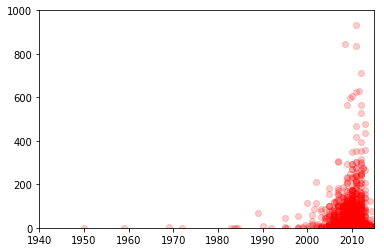

In [412]:
from scipy.stats import pearsonr, spearmanr

plt.plot(myref_table['year'], myref_table['eupcm_citations'], 'ro', alpha = 0.2)
plt.axis([1940, 2015, 0, 1000])

corr, _ = pearsonr(myref_table['year'], myref_table['eupcm_citations'])
print('Pearsons correlation: %.3f' % corr)


corr2, _ = spearmanr(myref_table['year'], myref_table['eupcm_citations'])
print('Spearmans correlation: %.3f' % corr2)

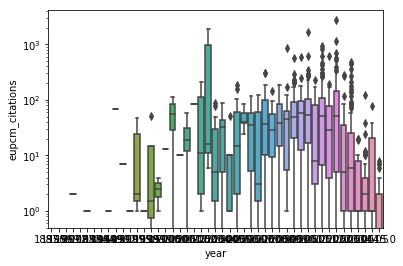

In [379]:
import seaborn as sns

ax = sns.boxplot(x='year', y='eupcm_citations', data=myref_table)
ax.set_yscale("log")

Wow! I actually expected that the number of citations would be higher for articles that cite more recent work. However, I found no evidence for that. 

THe high scoring points towards the right are likely to be only a side effect of having more points towards the right in total.


Conclusion:

For our sampling, the median year of references is not correlated to how cited a paper is in the following years. 

(For Nature papers published in 2015)

Let us see if it is a proxy for "hot" topics.  




In [407]:
old_topics =  [ "mitochondria", "brain", "vertebrate"]
new_topics = ["epigenetic", "CRISPR", "genomic" ]

In [401]:

matching = [s for s in myref_table["itemLabel"] if old_topics[0] in s]

print(matching)

['A cytosolic network suppressing mitochondria-mediated proteostatic stress and cell death', 'Energetic coupling between plastids and mitochondria drives CO2 assimilation in diatoms.', 'Mistargeted mitochondrial proteins activate a proteostatic response in the cytosol.', 'Regulation of mitochondrial morphology and function by stearoylation of TFR1.']


In [403]:


topic_age =[]
for index, row in myref_table.iterrows():
    
    if old_topics[0] in row["itemLabel"] or old_topics[1] in row["itemLabel"] or old_topics[2] in row["itemLabel"] :
        print(row["itemLabel"])
        topic_age.append('old_topic')
    elif new_topics[0] in row["itemLabel"] or new_topics[1] in row["itemLabel"] or new_topics[2] in row["itemLabel"] :
        print(row["itemLabel"])
        topic_age.append('new_topic')
    else:
        topic_age.append('na')

A cytosolic network suppressing mitochondria-mediated proteostatic stress and cell death
A new heart for a new head in vertebrate cardiopharyngeal evolution
Antibody against early driver of neurodegeneration cis P-tau blocks brain injury and tauopathy
Building global capacity for brain and nervous system disorders research.
Building the foundation for genomics in precision medicine.
CDA directs metabolism of epigenetic nucleosides revealing a therapeutic window in cancer
CRISPR adaptation biases explain preference for acquisition of foreign DNA
CRISPR-Cas immunity in prokaryotes.
Cas9 specifies functional viral targets during CRISPR-Cas adaptation.
Cognitive disorders: Deep brain stimulation for Rett syndrome.
Common genetic variants influence human subcortical brain structures
Comprehensive genomic characterization of head and neck squamous cell carcinomas
Comprehensive genomic profiles of small cell lung cancer.
Computer science: Nanoscale connections for brain-like circuits.
Conform

[(2000, 2020)]

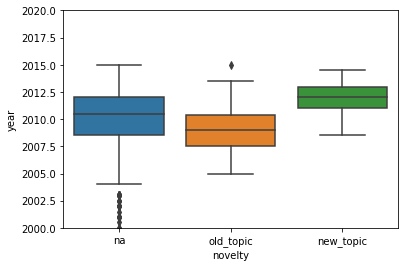

In [416]:

myref_table[""] = topic_age


ax = sns.boxplot(x='novelty', y='year', data=myref_table)

ax.set(ylim=(2000,2020))

Interesting! It seems that the papers about topics I considered novel indeed cite recent work, while older topics (as "mitochondria") have, on average older citations. 
